# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 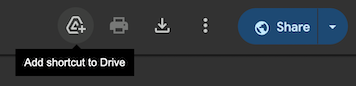

Скачаем данные для обучения и тестирования:

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
dataset = pd.read_csv('/content/drive/MyDrive/Data_Anal/HW6 NLP/salary_dataset.csv')
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [14]:
dataset.iloc[1]["FullDescription"]

'Our client is looking for a .net web developer with strong experience of of developing webbased applications using ASP.NET, JavaScript, AJAX, XML, XSLT and CSS. You will be able to design/develop and maintain databases using SQL and stored producers. You will have excellent problem solving skills and able to manage projects to tight declines. This is an excellent development role with great career progression'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [ ]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [ ]:
ordered_dict = <...>

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [ ]:
list(ordered_dict.items())[:10]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [ ]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [ ]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [ ]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    texts_tensors = <...>

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [ ]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [ ]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

Посмотрим на отмасштабированные значения зарплаты:

In [ ]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Сформируйте даталоадеры для обучения и валидации.

In [ ]:
train_loader = <...>
valid_loader = <...>

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [ ]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=...,
        rnn_num_units=...,
        output_dim=...
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()

        <...>

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """
        predictions = <...>
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [ ]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [ ]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        <...>

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            # Обучение на 1 батче, подсчет метрики
            <...>

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [ ]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

In [ ]:
# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

# Задайте параметры сети
model = SimpleRNNRegressor(<...>).to(device)
# Посмотрите на получившуюся модель
model

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

**Вывод:**

---
### Задача 2. Использование большой языковой модели


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!

In [3]:
!pip install bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2  > null
import transformers
import bitsandbytes as bnb

assert torch.cuda.is_available(), "для этой части понадобится GPU"

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...





От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [4]:
model_name = "TheBloke/Llama-2-13B-GPTQ"

# Загружаем Llama токенизатор
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    model_name, device_map=device
)
tokenizer.pad_token_id = tokenizer.eos_token_id

# И саму модель Llama
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Посмотрим на первую ЗП и попробуем её предсказать:

In [18]:
dataset.iloc[0]["SalaryNormalized"]

55000

In [13]:
prompt = """This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer.
You will be responsible for developing and executing recruiting plans across the company.
Your key accountabilities will include creating job descriptions, working closely with hiring managers,
reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts.
You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment.
Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe.
This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****. The salary for this job is """
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)


Output: <s> This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. 
You will be responsible for developing and executing recruiting plans across the company. 
Your key accountabilities will include creating job descriptions, working closely with hiring managers, 
reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. 
You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. 
Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. 
This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****. The salary for this job is 25,000 - 40,000 GBP.
You can view all our 779 current jobs at www.totaljobs.com/JobSeeking/index.asp.
</s>
Input batch (encoded): {'input_ids': tensor([[    1,   910,   

Посмотрим на вторую ЗП и попробуем её предсказать:

In [19]:
dataset.iloc[1]["SalaryNormalized"]

27500

In [15]:
prompt = """Our client is looking for a .net web developer with strong experience of of developing webbased applications using ASP.NET,
JavaScript, AJAX, XML, XSLT and CSS.
You will be able to design/develop and maintain databases using SQL and stored producers.
You will have excellent problem solving skills and able to manage projects to tight declines.
This is an excellent development role with great career progression The salary for this job is """
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)


Output: <s>Our client is looking for a .net web developer with strong experience of of developing webbased applications using ASP.NET, 
JavaScript, AJAX, XML, XSLT and CSS. 
You will be able to design/develop and maintain databases using SQL and stored producers. 
You will have excellent problem solving skills and able to manage projects to tight declines. 
This is an excellent development role with great career progression The salary for this job is 30 000 45 000 depending on experience. 
The candidate needs to have experience of working with: 
* Visual Studio 2005 or above. 
* Visual Studio Team Foundation Server (TFS) 
* Agile methodologies, including Sc
Input batch (encoded): {'input_ids': tensor([[    1,  8680,  3132,   338,  3063,   363,   263,   869,  1212,  1856,
         13897,   411,  4549,  7271,   310,   310, 14338,   591,  1327,  1463,
          8324,   773, 12738, 29889,  6006, 29892, 29871,    13, 16963, 29892,
         18891, 29892,  6560, 29892,  1060, 29903,  5850,  

Посмотрим на минимальную ЗП и попробуем её предсказать по описанию:

In [24]:
dataset[dataset["SalaryNormalized"] == dataset["SalaryNormalized"].min()].head()

,FullDescription,SalaryNormalized
6859,kids unlimited has a reputation as leaders in ...,5000
10444,"Development Team Leader C, ASP.Net, SQL Serve...",5000
10636,We are looking for a Web Developer to add to o...,5000
25371,Job Title: Customer Engineering & Delivery App...,5000
29977,Duration: 1 year fulltime Overview Ten scholar...,5000


In [27]:
prompt = """kids unlimited has a reputation as leaders in top quality, progressive childcare.
We are currently the 5th largest private daycare provider with over 60 nursery settings and an ever growing portfolio.
We have an exciting new opportunity for a Data Entry Apprentice to work in our Customer Service team.
The team has seen previous apprentices progress into permanent jobs upon finishing their course.
We are looking for a person who is keen to learn and can commit to doing an apprenticeship for **** year.
If successful we will enrol you on a NVQ in Business Administration.
You will be working for **** hours a week in our Central Office in Summerfields Village Centre near Wilmslow
and your NVQ assessor will come out to visit you every month.
With support you will be inputting the following data: finance information, application details and carer forms.
You will use both excel and our own systems (on which you will receive training) so it is essential you have an eye for accuracy and attention to detail.
The apprenticeship will also develop your data entry, analysis and reporting skills by inputting data into our systems and produce monthly reports.
You will also be required to support the Vouchers Team as and when required with other general admin duties.
This opportunity will be perfect for you if:  Want to learn while you earn.  Have excellent organisational skills.
Are confident and polite on the telephone.  Can build positive relationships quickly.
Have the ambition and drive to succeed.  Enjoy being busy with lots of different things to do.
Have great computer skills, as we use Word and Excel.
Want to work in a great place with plenty of development opportunities.
This is a fantastic opportunity to develop your career within a progressive and forwardthinking company.
The position is working **** hours a week e.g. from 9.00am – 4.30pm or **** – 5pm or **** – 5.30pm, earning **** a year.
Eligibility criteria does apply  e.g. holders of degrees are not eligible to receive government funding for an apprenticeship.
There is no age restriction on completing an apprenticeship.
kids unlimited have many benefits in place for staff as well as the security of knowing that you're working for a growing, dynamic and successful business.
kids unlimited is committed to safeguarding and promoting the welfare of all children in our care.
We will ensure that safeguarding is of paramount concern to all employees and as a business we adopt and adhere to safe recruitment practices.
Most roles within kids unlimited are subject to enhanced security checks with CRB/Disclosure Scotland disclosures,
the cost of which is paid for by kids unlimited.
 The salary for this job is """
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)


Output: <s> kids unlimited has a reputation as leaders in top quality, progressive childcare. 
We are currently the 5th largest private daycare provider with over 60 nursery settings and an ever growing portfolio. 
We have an exciting new opportunity for a Data Entry Apprentice to work in our Customer Service team. 
The team has seen previous apprentices progress into permanent jobs upon finishing their course. 
We are looking for a person who is keen to learn and can commit to doing an apprenticeship for **** year. 
If successful we will enrol you on a NVQ in Business Administration. 
You will be working for **** hours a week in our Central Office in Summerfields Village Centre near Wilmslow 
and your NVQ assessor will come out to visit you every month. 
With support you will be inputting the following data: finance information, application details and carer forms. 
You will use both excel and our own systems (on which you will receive training) so it is essential you have an eye for

Посмотрим на максимальную ЗП и попробуем её предсказать:

In [28]:
dataset[dataset["SalaryNormalized"] == dataset["SalaryNormalized"].max()].head()

,FullDescription,SalaryNormalized
25757,C++ Trading Developer Hedge Fund (High Frequen...,200000
31832,Our client currently oversees well over $**** ...,200000
39129,This progressive and profitable c10 partner We...,200000
138618,This City firm rsquo;s Hertfordshire office is...,200000
174755,Offshore Legal have been instructed by a leadi...,200000


In [29]:
dataset.loc[25757]["FullDescription"]

'C++ Trading Developer Hedge Fund (High Frequency / C++ / STL / Boost) Skills: C++, FIX, UNIX, STL, Boost, Python, Low Latency, High Frequency **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** This top Global Hedge Fund is looking for an experienced C++ Developer with experience in the Financial Industry as a High Frequency Trading Developer to join their team. This team is looking for smart and inquisitive people driven to revolutionize trading. You will be an individual who is looking for a new and high profile challenge, which can provide real opportunities for your career growth. Exceptional C++ programming experience, including STL libraries and Multithreading coding, Unix and Perl skills and source control essential. This is a great opportunity to work on bleeding edge C++ (UNIX / STL / BOOST) projects in the financial industry to further your career. For more information, please apply. If this role is of interest to you please apply directly for immediat

In [30]:
prompt = """C++ Trading Developer Hedge Fund (High Frequency / C++ / STL / Boost) Skills:
C++, FIX, UNIX, STL, Boost, Python, Low Latency, High Frequency **** **** **** **** **** **** **** **** **** **** **** **** **** **** ****
This top Global Hedge Fund is looking for an experienced C++ Developer with experience in the Financial Industry
as a High Frequency Trading Developer to join their team.
This team is looking for smart and inquisitive people driven to revolutionize trading.
You will be an individual who is looking for a new and high profile challenge, which can provide real opportunities for your career growth.
Exceptional C++ programming experience, including STL libraries and Multithreading coding, Unix and Perl skills and source control essential.
This is a great opportunity to work on bleeding edge C++ (UNIX / STL / BOOST) projects in the financial industry to further your career.
For more information, please apply.
If this role is of interest to you please apply directly for immediate consideration OR email your CVs to abul.kibrianjfsearch.com
OR call **** **** **** C++ Trading Developer Hedge Fund (High Frequency / C++ / STL / Boost)
Skills: C++, FIX, UNIX, STL, Boost, Python, Low Latency, High Frequency
 The salary for this job is """
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)


Output: <s>C++ Trading Developer Hedge Fund (High Frequency / C++ / STL / Boost) Skills: 
C++, FIX, UNIX, STL, Boost, Python, Low Latency, High Frequency **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** 
This top Global Hedge Fund is looking for an experienced C++ Developer with experience in the Financial Industry 
as a High Frequency Trading Developer to join their team. 
This team is looking for smart and inquisitive people driven to revolutionize trading. 
You will be an individual who is looking for a new and high profile challenge, which can provide real opportunities for your career growth. 
Exceptional C++ programming experience, including STL libraries and Multithreading coding, Unix and Perl skills and source control essential. 
This is a great opportunity to work on bleeding edge C++ (UNIX / STL / BOOST) projects in the financial industry to further your career. 
For more information, please apply. 
If this role is of interest to you please apply d

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

**Вывод:**

Дописали в конце вакансии `The salary for this job is` и нейросеть стала выдавать численные результаты по зарплате. Попробовали 4 раза. В целом, для вакансий с большой реальной зарплатой - предсказания выше. То есть, нейросеть худо бедно справляется.

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*